# [Ex-06] : 작사가 인공지능 만들기

1. 목표

    1.1 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?
    
    1.2 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?
    
    1.3 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?
</br></br>
2. 개인적 목표

    2.1 프로젝트 시작 이전에, Simple RNN과 LSTM에 대한 섬세한 이해

# 1. Init

## 1.1 필요한 Library 및 Module import

In [2]:
import os, re
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.11.0


## 1.2 목차

1. Init

    1.1 필요한 Library 및 Module import
    
    1.2 목차
    

2. 프로젝트 이전 RNN 학습에 대한 섬세한 이해

    2.1 데이터 불러오기
    
    2.2 전처리
    
    2.3 모델링
    
    2.4 문장 생성


3. 프로젝트 진행

    
4. 회고

# 2. 프로젝트 이전 RNN 학습에 대한 섬세한 이해

## 2.1 데이터 불러오기

In [3]:
sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


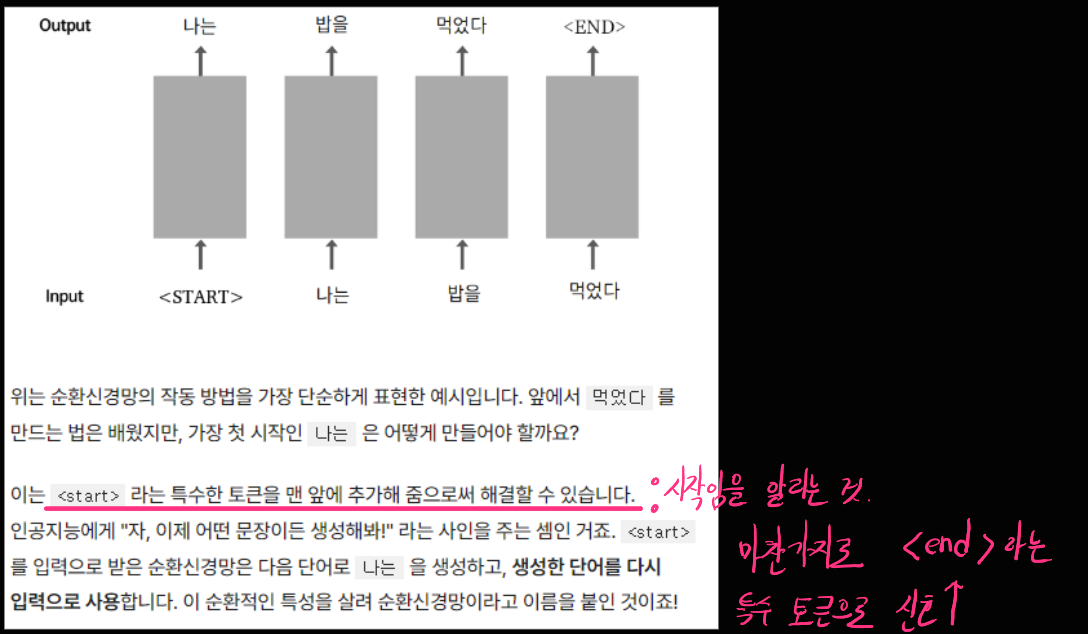

* RNN이란?

문장이나 영상, 음성 데이터는 이미지 데이터와는 다르게 순차적인 특성(Sequential Feature)이 있다. 단어 별 사용할 수 있는 맥락이 있고 그 맥락은 앞뒤로 상호 연결되어 있기 때문이다. Sequential Data의 요소 연관성을 모델에 학습시키기 위해 고안된 것이 바로 RNN이다.


이러한 Language Model은, w1~wn-1까지 앞에 입력됐을 때 wn이 출력될 확률분포를 계산하는 것과 같다. 

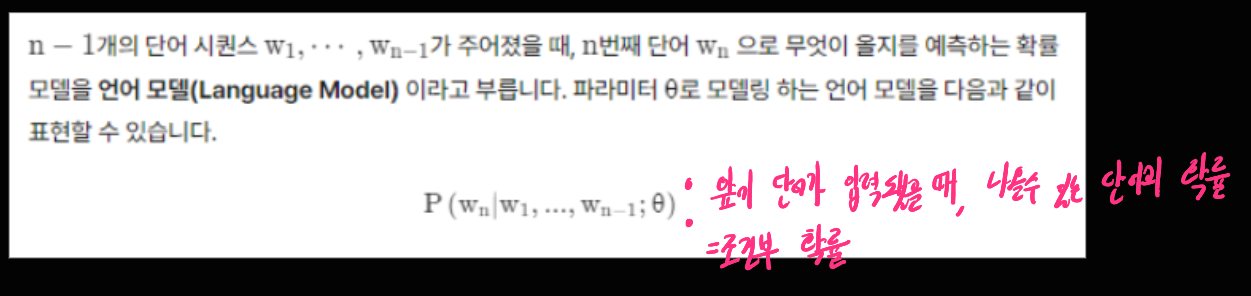

In [4]:
dir_path = os.getenv("USERPROFILE") + "\\Desktop\\aiffel_online_research\\[Exploration]\\[Ex-06]"
file_path = os.path.join(dir_path, "shakespeare.txt")

with open(file_path, 'r') as f:
    raw_corpus = f.read().splitlines()
    
print(raw_corpus[:10])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '', 'All:']


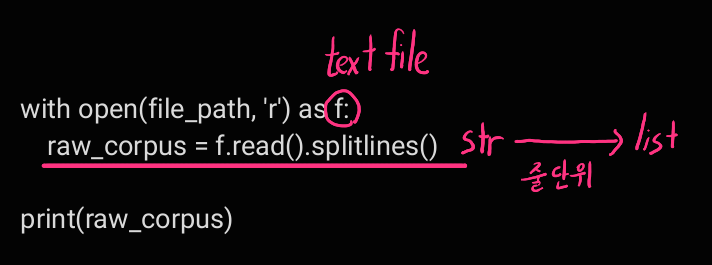

* Tokenize란?

이러한 문장엔 아직 데이터로 삼기에 부족한 문장이 있다. 줄 단위로 끊다보니 빈줄로 넘어간 것은 ''으로 저장된다. 그러므로 길이가 0인 문장은 제외해야 한다. 희곡 형식으로 되어 있어서 등장인물을 알리는 표시가 있다. 따라서 ':'로 끝나는 문장도 제외해야 한다. 이를 정리하면 다음과 같다.

1.:로 끝나는 문장 제외

2.길이가 0인 문장 제외


유의미한 단어만을 모아 사전을 만드는 것을 Tokenize라고 한다. 우린, 1,2를 조건을 삼아서 사전을 만들 것이다. 

## 2.2 전처리

In [5]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    if idx > 9: break
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'[^a-zA-Z?.!,¿]+', " ",sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [7]:
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


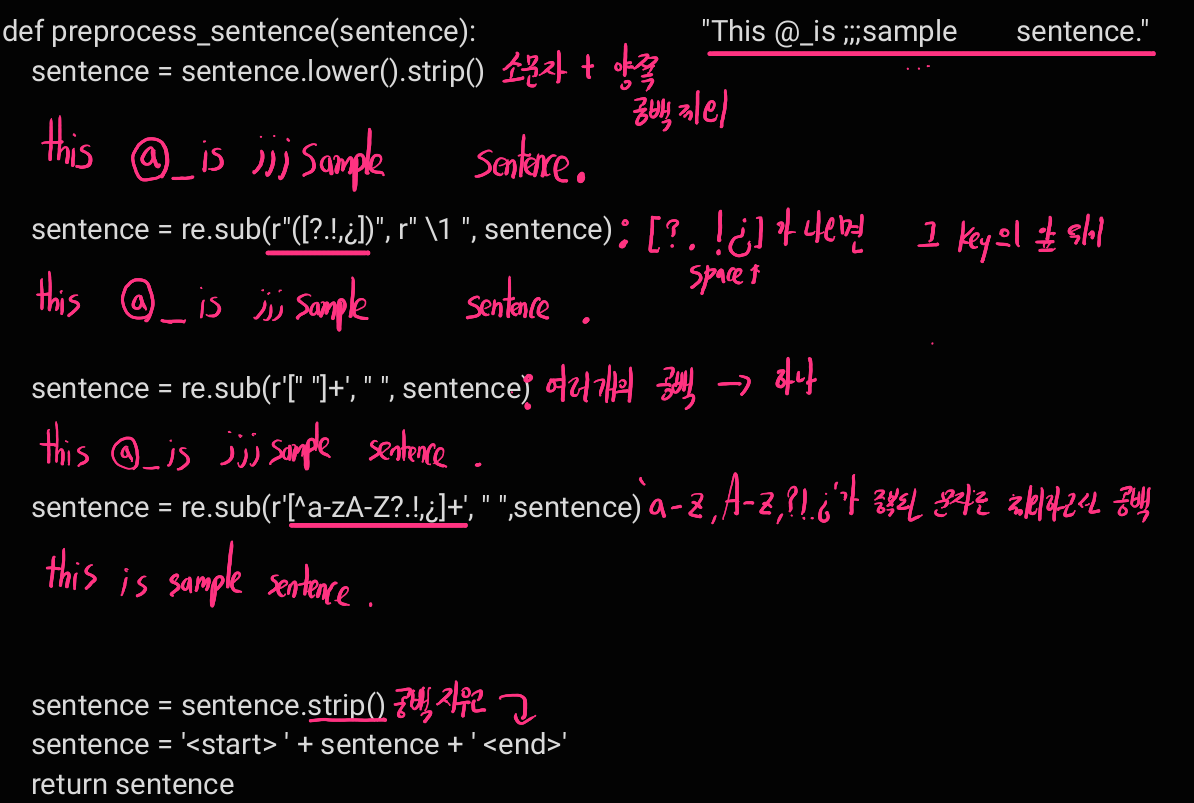

In [8]:
corpus = []

for sentence in raw_corpus:
    if len(sentence)  == 0: continue
    if sentence[-1] == ":": continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

## 2.3 모델링

In [9]:
def tokenize(corpus):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token='<unk>'
    )
    
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=20)

    return tensor, tokenizer

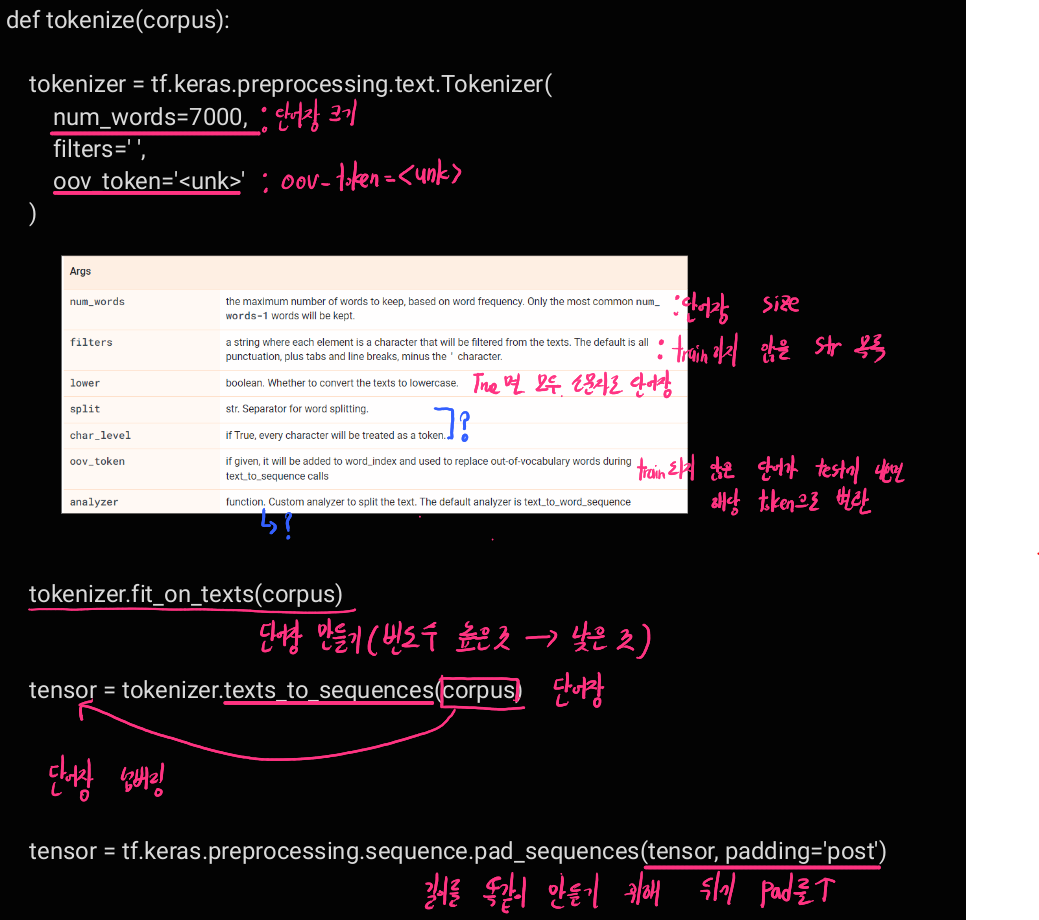

In [10]:
tensor, tokenizer = tokenize(corpus)

* tensor의 shape이 (24015, 20)인 것은 20개의 단어로 이루어진 문장이 24015개 있다는 뜻이다.

In [11]:
tensor.shape

(24015, 20)

In [12]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


In [13]:
print(tensor.shape)
src_input = tensor[:, :-1]  
print(tensor[:,:-1].shape)
tgt_input = tensor[:, 1:]
print(tensor[:,1:].shape)

(24015, 20)
(24015, 19)
(24015, 19)


* 질문 1: 9565번째 문장은 길이가 21인데, maxlen = 20으로 하면 맨 앞 토큰이 잘린다. 이렇게 잘려도 되는 것인가?

=> 단어 간의 연관성을 모델에 학습시키는 것이 주 목적인데, 단어 하나가 덜 학습된다고 결과에 큰 영향을 미치진 않을 것이다. 만약 maxlen을 설정하지 않았다면, 모든 문장에 0이란 token이 하나씩 더 생겨서 0이 과 학습될 가능성도 있다.

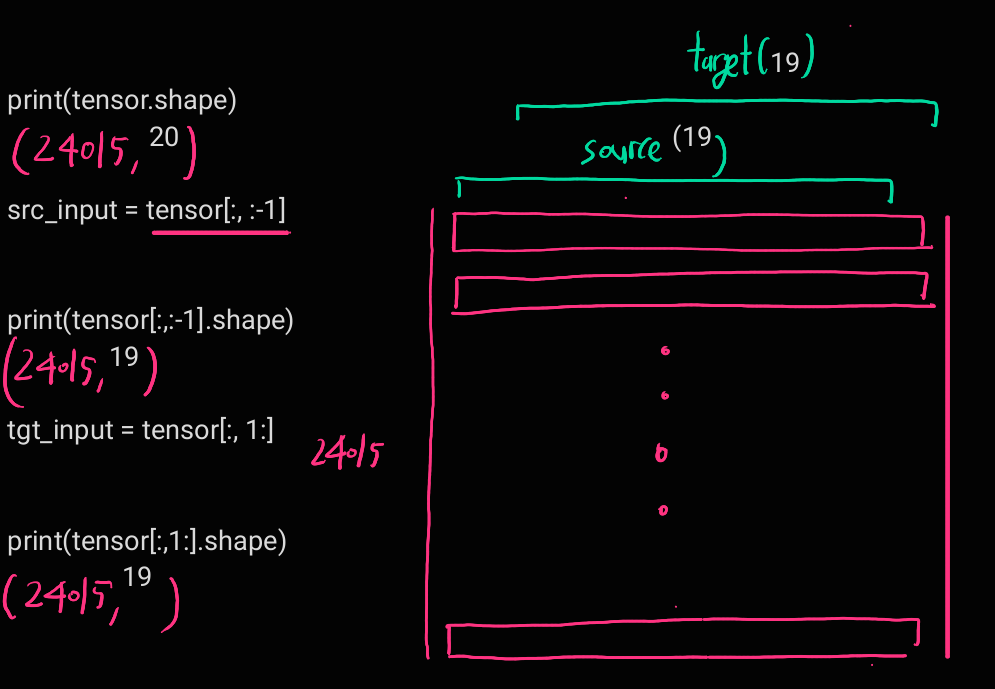

In [14]:
BUFFER_SIZE = len(src_input)
print(BUFFER_SIZE)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
print(steps_per_epoch)

VOCAB_SIZE = tokenizer.num_words + 1

24015
93


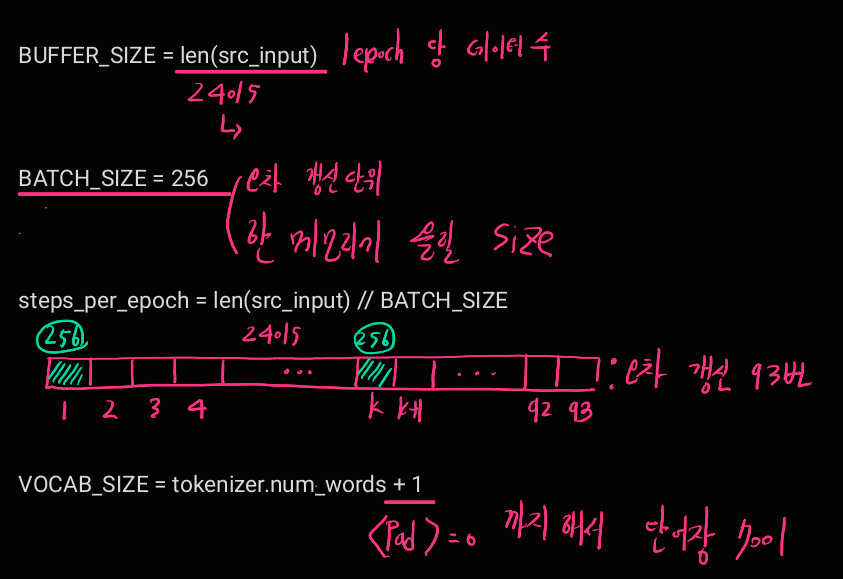

In [15]:
print(src_input.shape)
print(tgt_input.shape)

(24015, 19)
(24015, 19)


In [16]:
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

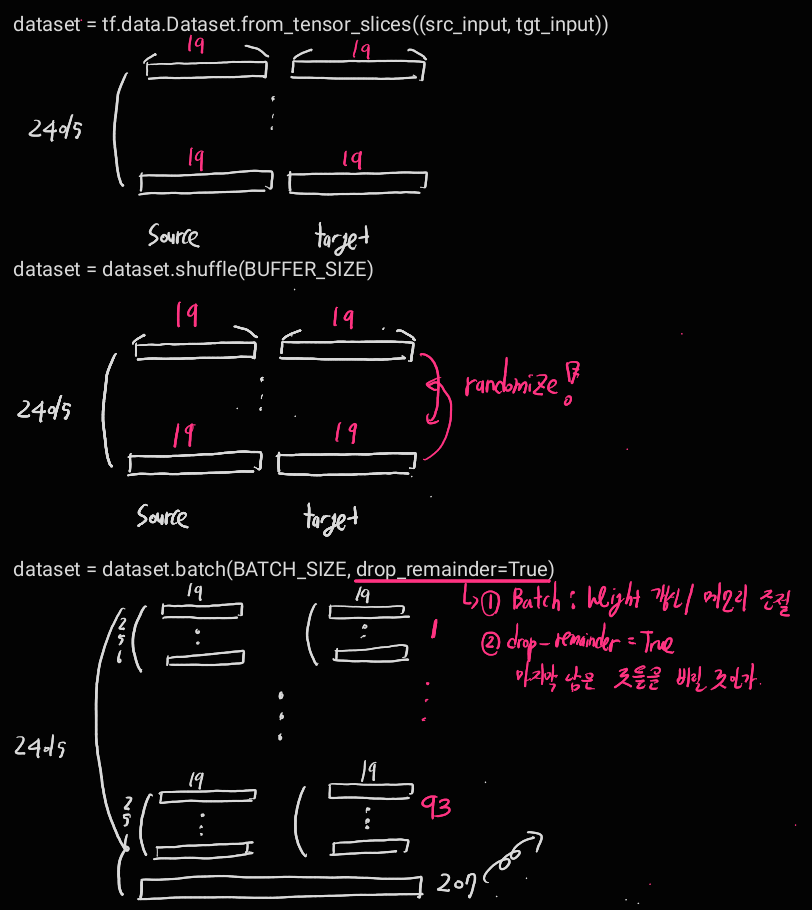

In [18]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

* 최종적인 말 하나가 필요한 게 아니라 과정에서 나오는 모든 말이 중요하기 때문에 return_sequences=True


* embedding size 값이 커질수록 단어의 추상적인 특징을 잡아낼 수 있지만 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져온다. 

In [19]:
embedding_size = 256
hidden_size = 1024
VOCAB_SIZE = tokenizer.num_words + 1
#단어장 사이즈 = 7001
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

#### Embedding Layer
: Embedding Layer의 기능은 두 가지로 분류된다. 첫 번째는 token화 된 문장을 one-hot-vector로 바꾸는 작업이다. 두 번째는 이를 embedding_size로 의미 분류하는 것이다.

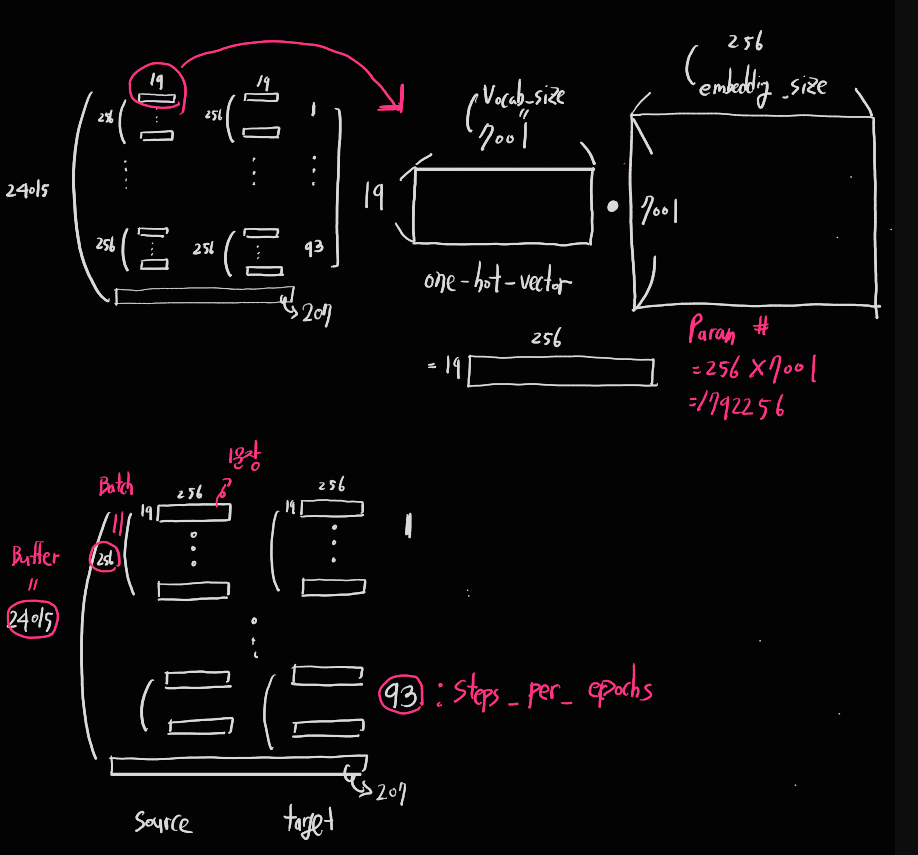

#### RNN1 

: RNN은 문장 간의 연관성을 학습하는 작업이다. LSTM은 simple rnn의 gradient vanishg문제를 해결할 대체제이다. 

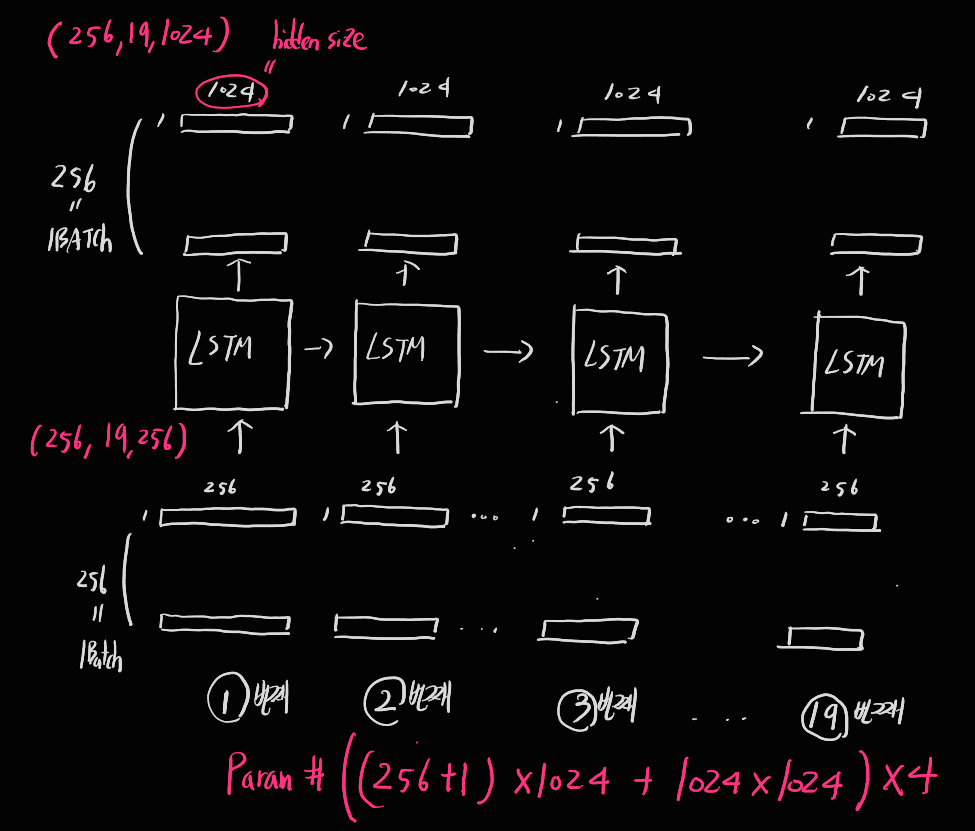

#### RNN2

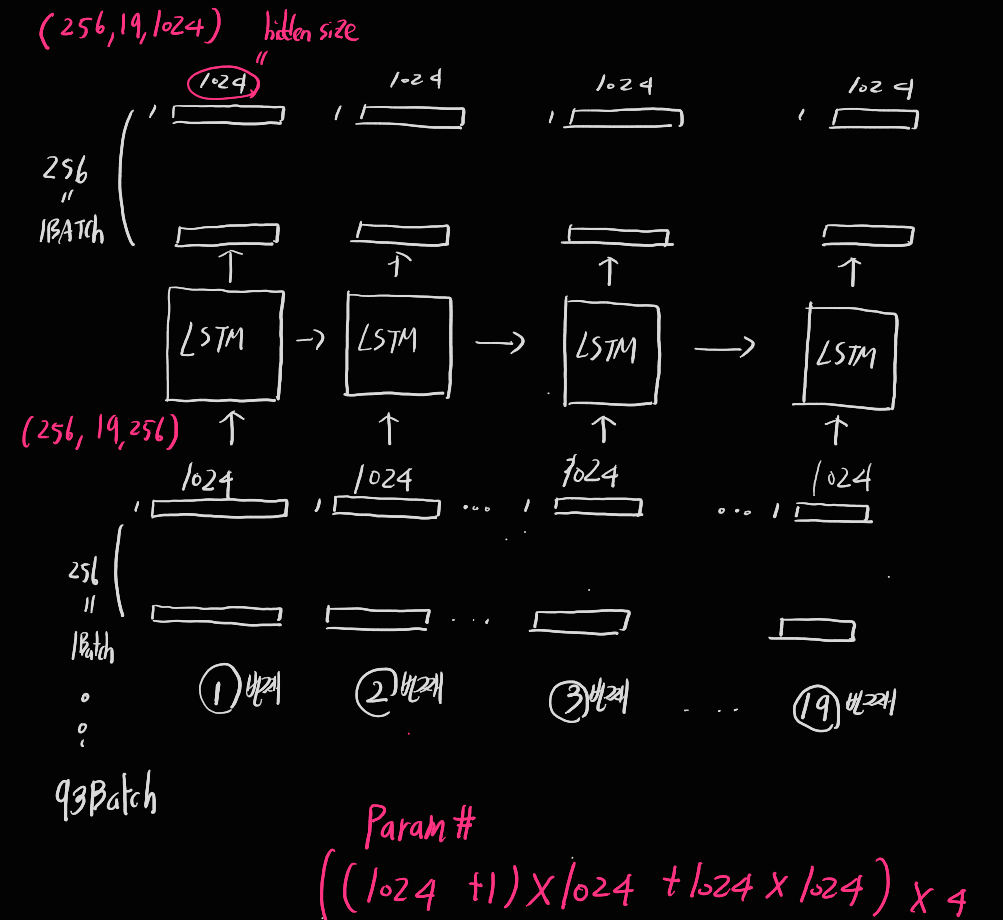

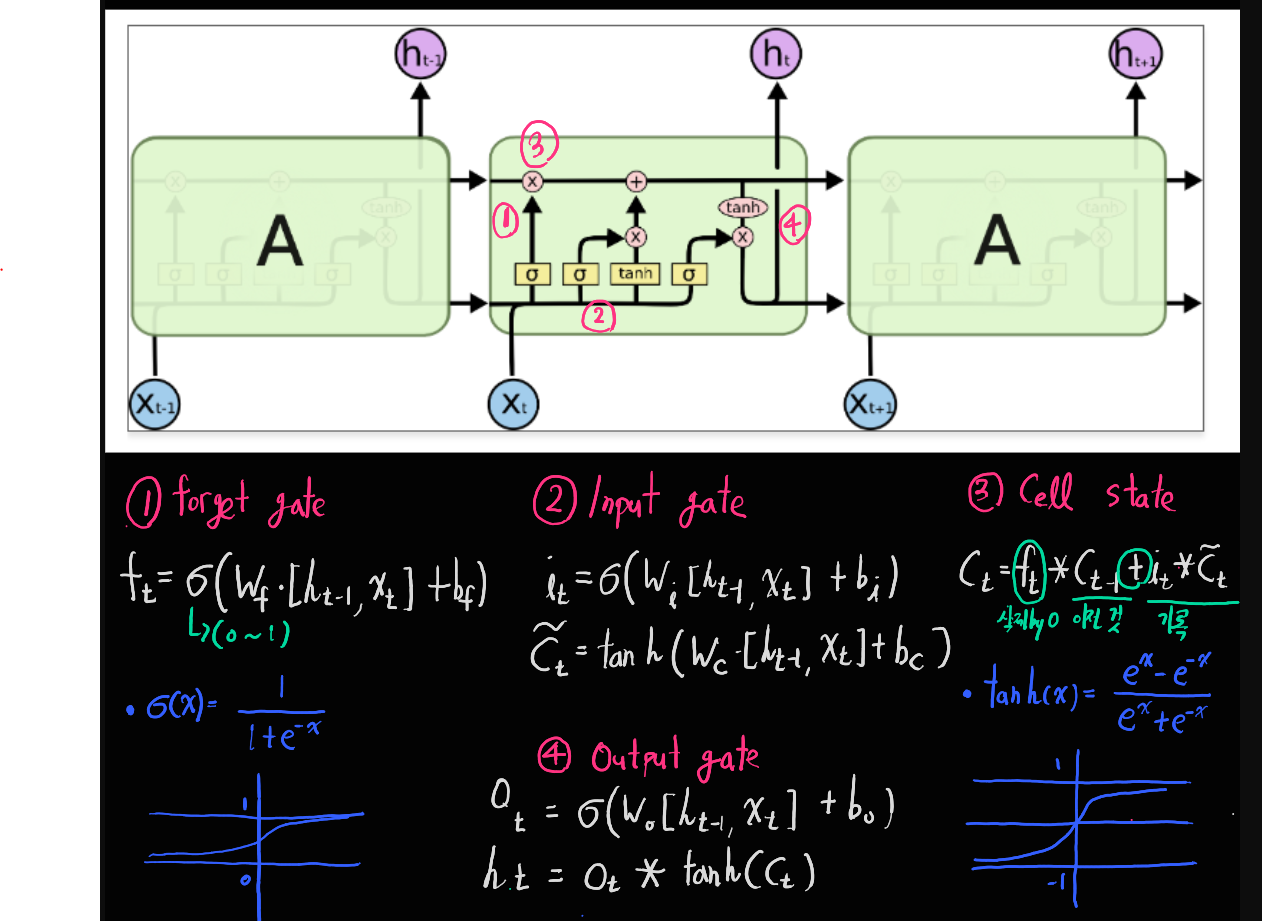

#### Dense Linear

: 한 문장을 7001개의 토큰으로 분류한다.

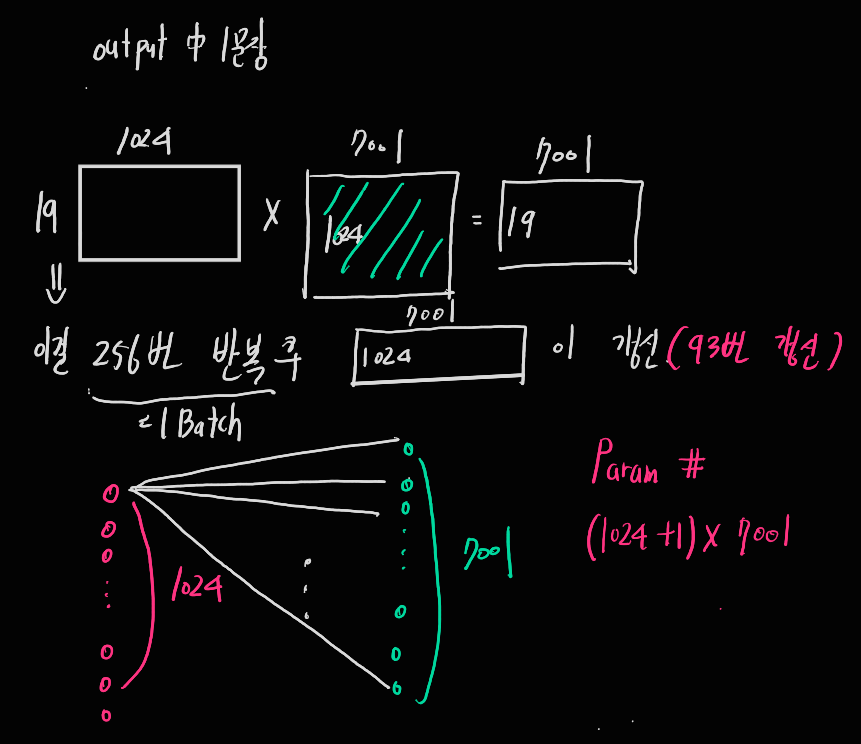

In [20]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

In [21]:
for src_sample, tgt_sample in dataset.take(1):
    print(src_sample)
    print(tgt_sample)
    break

tf.Tensor(
[[   2   59 2564 ...    0    0    0]
 [   2   29 1429 ...    0    0    0]
 [   2   32    9 ...    0    0    0]
 ...
 [   2  406   28 ...    0    0    0]
 [   2   14   12 ...    0    0    0]
 [   2   87  107 ...    0    0    0]], shape=(256, 19), dtype=int32)
tf.Tensor(
[[  59 2564   14 ...    0    0    0]
 [  29 1429    1 ...    0    0    0]
 [  32    9  231 ...    0    0    0]
 ...
 [ 406   28    9 ...    0    0    0]
 [  14   12 1556 ...    0    0    0]
 [  87  107 4673 ...    0    0    0]], shape=(256, 19), dtype=int32)


In [22]:
model(src_sample)

<tf.Tensor: shape=(256, 19, 7001), dtype=float32, numpy=
array([[[-2.08312558e-05,  1.83347991e-04, -2.65656854e-06, ...,
         -3.87620967e-05, -1.81062496e-04,  3.27770744e-04],
        [ 1.60309661e-04,  2.12676197e-04,  1.76558402e-04, ...,
         -1.41023032e-04, -1.27244915e-04,  5.80678286e-04],
        [ 1.04155624e-04,  2.89444841e-04, -6.67832574e-05, ...,
         -4.03288519e-04, -1.79758877e-04,  1.07731868e-03],
        ...,
        [-6.63612911e-04,  1.00275982e-04,  8.62270186e-04, ...,
         -5.90240990e-04, -1.89021160e-03, -1.51862251e-03],
        [-8.72073811e-04, -6.29004571e-05,  7.67610152e-04, ...,
         -9.25944012e-04, -2.17484636e-03, -1.41669670e-03],
        [-1.07803906e-03, -1.83135853e-04,  6.61614176e-04, ...,
         -1.32204546e-03, -2.42217118e-03, -1.28362817e-03]],

       [[-2.08312558e-05,  1.83347991e-04, -2.65656854e-06, ...,
         -3.87620967e-05, -1.81062496e-04,  3.27770744e-04],
        [-1.97991903e-05,  2.88582989e-04, -1.

In [23]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1792256   
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 lstm_1 (LSTM)               multiple                  8392704   
                                                                 
 dense (Dense)               multiple                  7176025   
                                                                 
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


* optimizer엔 여러 종류가 있지만, 어떤 걸 사용하는 것이 좋을지 잘 모르는 상황이라면 Adam이 무난하게 사용하기 좋다.
</br>

* loss 함수는 분류가 2종류일 때엔 Binary cross entropy를 다수를 분류할 땐 categoricalcrossentropy를 사용한다. 이 때 label이 정수형으로 나타난다면 sparse categorical cross entropy를 사용한다. 

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

model.compile(loss=loss, optimizer=optimizer)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'  
)
model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=5)

Epoch 1/5
93/93 [==============================] - 456s 5s/step - loss: 3.7580
Epoch 2/5
93/93 [==============================] - 486s 5s/step - loss: 2.9800
Epoch 3/5
93/93 [==============================] - 437s 5s/step - loss: 2.9057
Epoch 4/5
93/93 [==============================] - 418s 4s/step - loss: 2.8229
Epoch 5/5
93/93 [==============================] - 429s 5s/step - loss: 2.7480


## 2.4 문장 생성

In [27]:
embedding_size = 256
hidden_size = 1024
VOCAB_SIZE = tokenizer.num_words + 1
#단어장 사이즈 = 7001
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [28]:
def generate_text(model, tokenizer, init_sentence = "<start>", max_len = 20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""

    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated 

In [30]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he answer climb wives wives climate dateless dateless dateless venice venice venice private private hereafter pernicious pernicious pernicious pernicious '

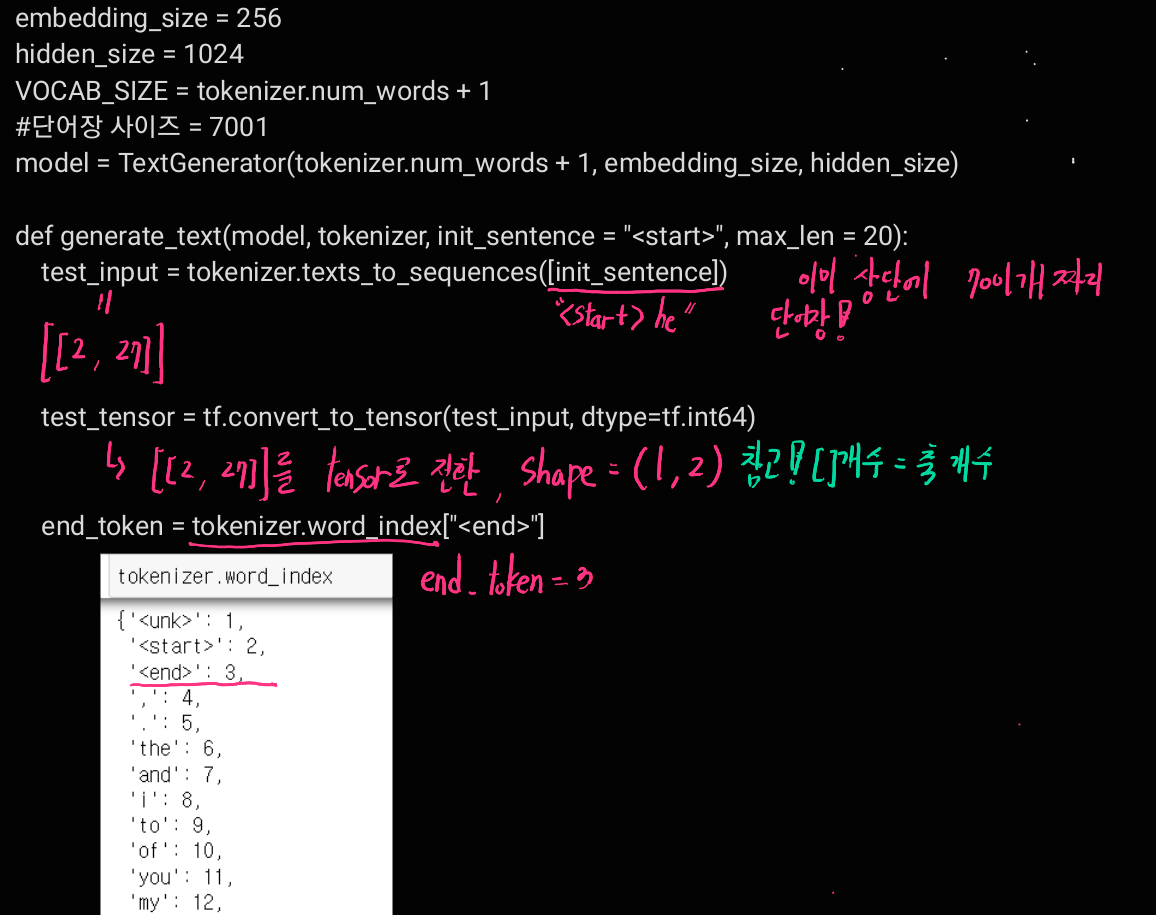

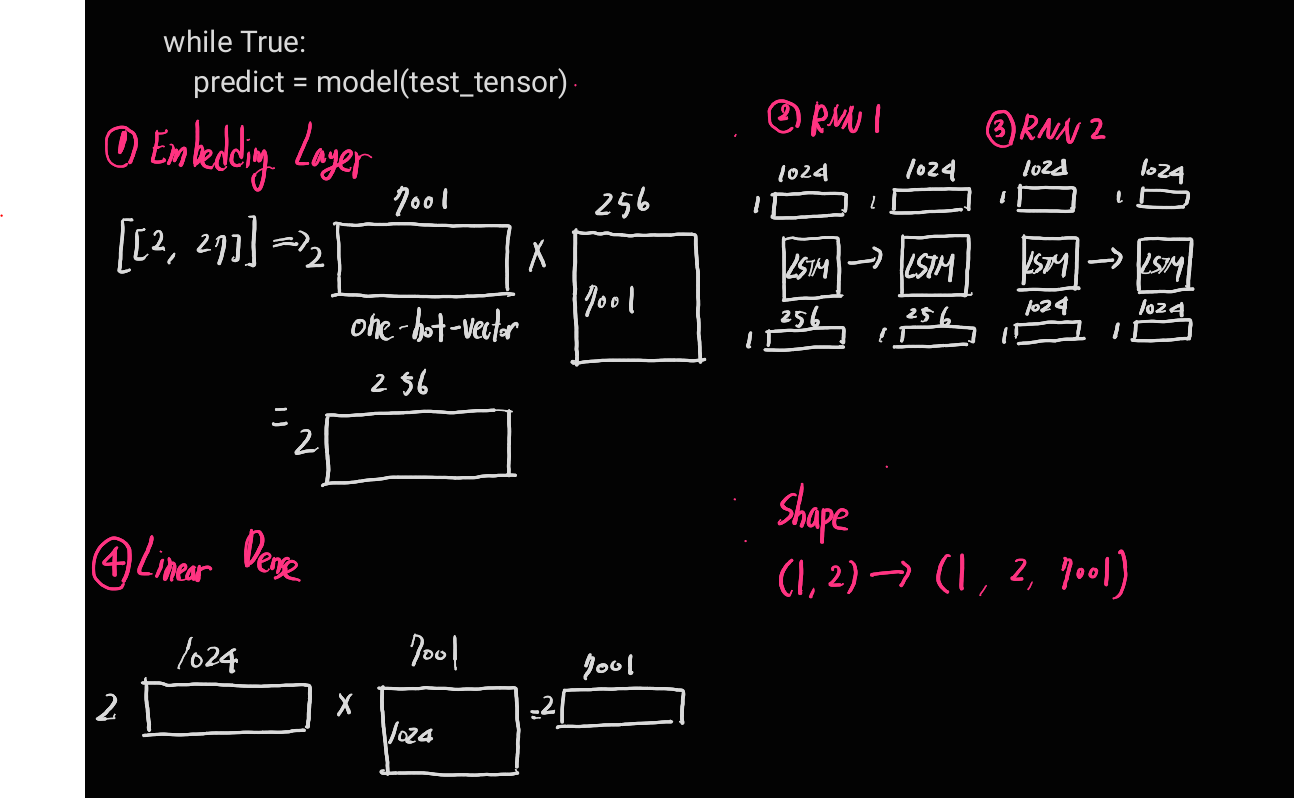

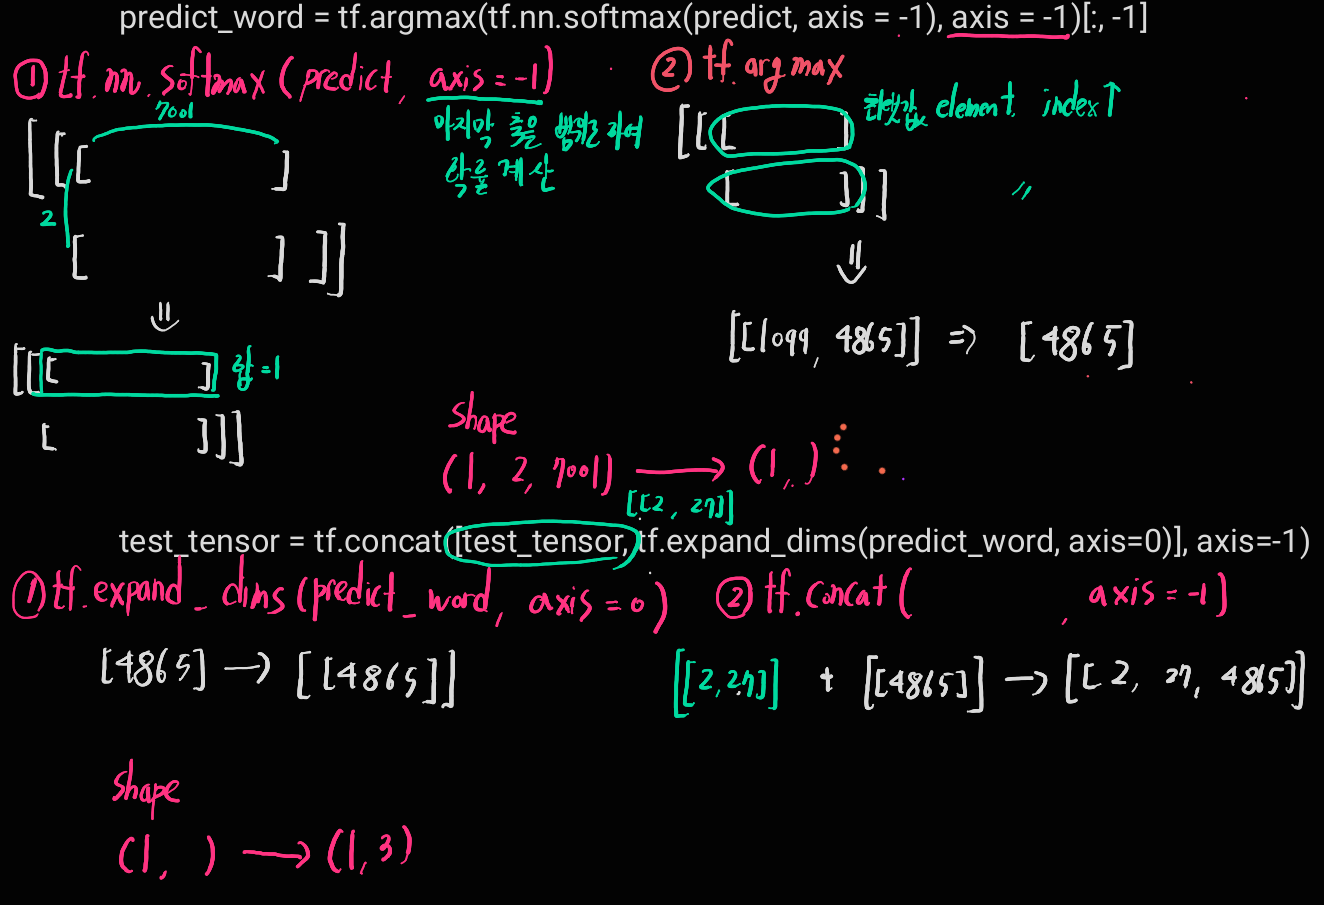

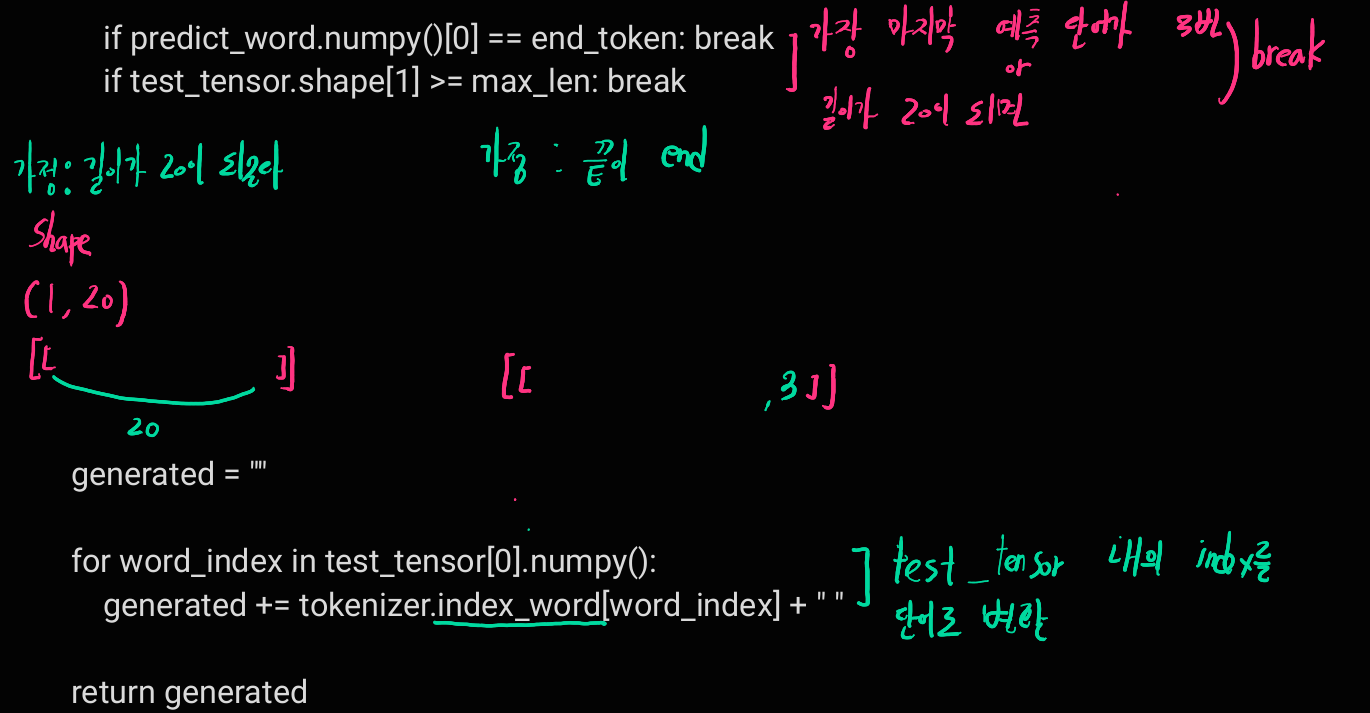